In [1]:
import torch

In [2]:
torch.__version__

'1.7.1'

## Self Attention
- Self attention is the only operation *between* vectors in transformers. All other operation is applied to each vector in the input sequence w/o interactions between vectors
- We are learning what weights $w_{ij}$ should be, so their values is completely dependent on the task in hand
- **Basic intuition** $\rightarrow$ dot product express how related two vectors in the input sequence are
- Self attention sees input as a *set*, not as a sequence $\rightarrow$ **permutation invariant**

In [69]:
import torch, os

def mask_(matrices, maskval=0.0, mask_diagonal=True):
    """
    Masks out all values in the given batch of matrices where i <= j holds,
    i < j if mask_diagonal is false
    In place operation
    :param tns:
    :return:
    """

    b, h, w = matrices.size()

    indices = torch.triu_indices(h, w, offset=0 if mask_diagonal else 1)
    matrices[:, indices[0], indices[1]] = maskval

def d(tensor=None):
    """
    Returns a device string either for the best available device,
    or for the device corresponding to the argument
    :param tensor:
    :return:
    """
    if tensor is None:
        return 'cuda' if torch.cuda.is_available() else 'cpu'
    return 'cuda' if tensor.is_cuda else 'cpu'

def here(subpath=None):
    """
    :return: the path in which the package resides (the directory containing the 'former' dir)
    """
    if subpath is None:
        return os.path.abspath(os.path.join(os.path.dirname(__file__), '../..'))

    return os.path.abspath(os.path.join(os.path.dirname(__file__), '../..', subpath))

def contains_nan(tensor):
    return bool((tensor != tensor).sum() > 0)

## Implementation in PyTorch

- t $\rightarrow$ lenght of the input vector
- k $\rightarrow$ dimension of the input vector
- b $\rightarrow$ minibatch dimension

- Input $\rightarrow$ **(b, t, k)**

In [70]:
import torch
import torch.nn.functional as F

In [71]:
k = 512
t = 20
b = 32

In [72]:
x = torch.rand(b,t,k)
x.shape

torch.Size([32, 20, 512])

In [73]:
x[0][0].shape

torch.Size([512])

In [74]:
x.transpose(1,2).shape

torch.Size([32, 512, 20])

In [75]:
x.transpose(0,1).shape

torch.Size([20, 32, 512])

In [76]:
x.transpose(0,2).shape

torch.Size([512, 20, 32])

In [77]:
raw_weights = torch.bmm(x, x.transpose(1,2))
raw_weights.shape

torch.Size([32, 20, 20])

In [78]:
weights = F.softmax(raw_weights, dim=2)

In [79]:
weights.shape

torch.Size([32, 20, 20])

In [80]:
x.shape

torch.Size([32, 20, 512])

In [81]:
output_seq = torch.bmm(weights, x)
output_seq.shape

torch.Size([32, 20, 512])

In [82]:
weights[0][0]

tensor([1.0000e+00, 6.8309e-20, 1.3575e-15, 2.0298e-16, 5.1996e-17, 4.2063e-17,
        1.3181e-14, 3.5323e-18, 7.2735e-18, 6.0867e-17, 7.9257e-16, 1.1209e-17,
        4.6487e-16, 7.5263e-18, 7.8510e-21, 6.8424e-18, 1.3988e-16, 1.7266e-16,
        1.1696e-17, 5.8822e-15])

In [83]:
from matplotlib.pyplot import imshow

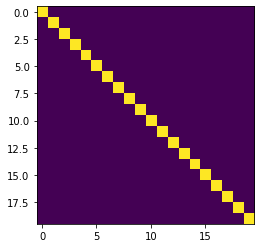

In [84]:
imshow(weights[0])

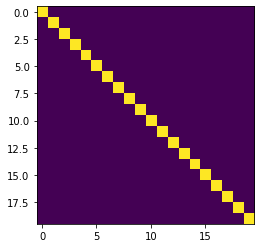

In [85]:
imshow(weights[1])

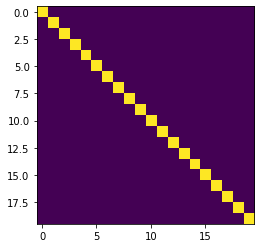

In [86]:
imshow(weights[2])

## Full Self Attention with Queries, Keys, Values

Roles of each input vector $w_{i}$
- **Query** $\rightarrow$ compare to every other vector to establish weights for its own input $y_{i}$
- **Key** $\rightarrow$ compare to every other vector to establish weights for the output of the j-th vector $y_{j}$
- **Values** $\rightarrow$ it is used as part of the weighted sum to compute each output vector once the weights have been established


In [87]:
import torch
from torch import nn
import torch.nn.functional as F
import random, math

In [92]:
class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8, mask=False):
        """
        :param emb:
        :param heads:
        :param mask:
        """

        super().__init__()

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)

        self.unifyheads = nn.Linear(heads * emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))
        dot = dot / math.sqrt(e) # dot contains b*h  t-by-t matrices with raw self-attention logits

        assert dot.size() == (b*h, t, t), f'Matrix has size {dot.size()}, expected {(b*h, t, t)}.'

        if self.mask: # mask out the lower half of the dot matrix,including the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)

        dot = F.softmax(dot, dim=2) # dot now has row-wise self-attention probabilities

        assert not contains_nan(dot[:, 1:, :]) # only the forst row may contain nan

        if self.mask == 'first':
            dot = dot.clone()
            dot[:, :1, :] = 0.0
            # - The first row of the first attention matrix is entirely masked out, so the softmax operation results
            #   in a division by zero. We set this row to zero by hand to get rid of the NaNs

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e)

        return self.unifyheads(out)

In [93]:
embed_dim =100
n_heads = 4

attn = SelfAttention(emb=embed_dim, heads=n_heads)
attn

SelfAttention(
  (tokeys): Linear(in_features=100, out_features=400, bias=False)
  (toqueries): Linear(in_features=100, out_features=400, bias=False)
  (tovalues): Linear(in_features=100, out_features=400, bias=False)
  (unifyheads): Linear(in_features=400, out_features=100, bias=True)
)

In [101]:
seq_lenght = 200
b_size =16
x = torch.rand(b_size, seq_lenght, embed_dim)
x.shape

torch.Size([16, 200, 100])

In [102]:
x.size()

torch.Size([16, 200, 100])

In [111]:
h = n_heads
h

4

In [112]:
b, t, e = x.size()
b, t, e

(16, 200, 100)

In [123]:
queries = attn.toqueries(x).view(b,t,e, h)
keys = attn.tokeys(x).view(b,t,e, h)
values = attn.tovalues(x).view(b,t,e, h)

In [124]:
queries.shape, keys.shape, values.shape

(torch.Size([16, 200, 100, 4]),
 torch.Size([16, 200, 100, 4]),
 torch.Size([16, 200, 100, 4]))

In [125]:
# - fold heads into the batch dimension
keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
values = values.transpose(1, 2).contiguous().view(b * h, t, e)

In [126]:
queries.shape, keys.shape, values.shape

(torch.Size([64, 200, 100]),
 torch.Size([64, 200, 100]),
 torch.Size([64, 200, 100]))

In [136]:
# - get dot product of queries and keys, and scale
dot = torch.bmm(queries, keys.transpose(1, 2))
print(dot.shape)
print(dot.mean())
dot = dot / math.sqrt(e) # dot contains b*h  t-by-t matrices with raw self-attention logits

torch.Size([64, 200, 200])
tensor(0.1430, grad_fn=<MeanBackward0>)


In [137]:
dot.shape, dot.mean()

(torch.Size([64, 200, 200]), tensor(0.0143, grad_fn=<MeanBackward0>))

In [138]:
dot

tensor([[[ 1.6648e-01,  1.8130e-01,  1.4998e-01,  ...,  1.9634e-01,
           1.3229e-01,  2.5056e-01],
         [ 2.7216e-01,  1.7333e-01,  2.0434e-01,  ...,  1.8997e-01,
           1.4760e-01,  2.5760e-01],
         [ 1.7306e-01,  1.0894e-01,  1.4759e-01,  ...,  1.5102e-01,
           1.2370e-01,  1.5106e-01],
         ...,
         [-4.4215e-01, -3.7666e-01, -3.5990e-01,  ..., -3.7449e-02,
          -1.2372e-01, -1.5333e-01],
         [-2.9236e-01, -4.1911e-01, -3.6764e-01,  ..., -3.7292e-02,
          -9.2219e-02, -1.1336e-01],
         [-3.9456e-01, -4.6761e-01, -4.5902e-01,  ..., -9.0837e-02,
          -1.0957e-01, -2.1539e-01]],

        [[-2.4625e-01, -2.6120e-01, -2.2405e-01,  ..., -1.5732e-01,
          -3.2021e-01, -1.8951e-01],
         [-2.0286e-01, -2.7717e-01, -1.9271e-01,  ..., -2.6199e-01,
          -3.2021e-01, -2.1984e-01],
         [-1.9553e-01, -2.5184e-01, -2.2192e-01,  ..., -1.6762e-01,
          -2.8020e-01, -1.9099e-01],
         ...,
         [-8.0675e-02,  3

In [99]:
attn.forward(x)

tensor([[[-0.1791, -0.1709, -0.2172,  ..., -0.1068, -0.0801, -0.1088],
         [-0.1797, -0.1715, -0.2185,  ..., -0.1053, -0.0816, -0.1105],
         [-0.1797, -0.1715, -0.2188,  ..., -0.1074, -0.0815, -0.1110],
         ...,
         [-0.1795, -0.1701, -0.2178,  ..., -0.1067, -0.0823, -0.1082],
         [-0.1795, -0.1708, -0.2178,  ..., -0.1065, -0.0806, -0.1103],
         [-0.1787, -0.1706, -0.2192,  ..., -0.1050, -0.0814, -0.1099]],

        [[-0.0741, -0.1324, -0.1654,  ..., -0.1543, -0.0711, -0.1105],
         [-0.0741, -0.1321, -0.1664,  ..., -0.1543, -0.0702, -0.1111],
         [-0.0737, -0.1315, -0.1668,  ..., -0.1561, -0.0688, -0.1084],
         ...,
         [-0.0737, -0.1325, -0.1664,  ..., -0.1535, -0.0697, -0.1082],
         [-0.0735, -0.1316, -0.1658,  ..., -0.1541, -0.0697, -0.1108],
         [-0.0732, -0.1322, -0.1664,  ..., -0.1565, -0.0683, -0.1099]],

        [[-0.1489, -0.1558, -0.2270,  ..., -0.1053, -0.1041, -0.0720],
         [-0.1480, -0.1560, -0.2272,  ..., -0

## Sources
 - http://peterbloem.nl/blog/transformers